In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1 Physical GPUs, 1 Logical GPU


# Завдання 1
1.  Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 
Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  
Датасети для перекладу можна брати тут: https://www.manythings.org/anki/
Тексти українською для навчання генеративних моделей: https://www.kaggle.com/datasets/mykras/ukrainian-texts
Приклади:
https://keras.io/examples/nlp/neural_machine_translation_with_transformer/
https://keras.io/examples/nlp/lstm_seq2seq/
https://keras.io/examples/generative/lstm_character_level_text_generation/

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [4]:
dataset_path = "/kaggle/input/en-ua-dataset/ukr.txt"
batch_size = 64
epochs = 40
latent_dim = 256
num_samples = 10000

In [5]:
def read_language_dataset(path):
    text_en = []
    text_ukr = []
    chars_en = set()
    chars_ukr = set()
    with open(path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
    
    for line in lines[: min(num_samples, len(lines) - 1)]:
        input_text, target_text, _ = line.split("\t")
        # We use "tab" as the "start sequence" character
        # for the targets, and "\n" as "end sequence" character.
        target_text = "\t" + target_text + "\n"
        text_en.append(input_text)
        text_ukr.append(target_text)
        for ch in input_text:
            if ch not in chars_en:
                chars_en.add(ch)
        for ch in target_text:
            if ch not in chars_ukr:
                chars_ukr.add(ch)
    return text_en, text_ukr, chars_en, chars_ukr

In [6]:
text_en, text_ukr, chars_en, chars_ukr = read_language_dataset(dataset_path)

for _ in range(5):
    print(text_en[_])
    print(text_ukr[_])

Go.
	Йди.

Hi.
	Вітаю!

Hi.
	Привіт.

Hi.
	Привіт!

Run!
	Біжіть!



In [7]:
chars_en = sorted(list(chars_en))
chars_ukr = sorted(list(chars_ukr))
num_encoder_tokens = len(chars_en)
num_decoder_tokens = len(chars_ukr)
max_encoder_seq_length = max([len(txt) for txt in text_en])
max_decoder_seq_length = max([len(txt) for txt in text_ukr])

#input_token_index = dict([(ch, i) for i, ch in enumerate(chars_en)])
#target_token_index = dict([(ch, i) for i, ch in enumerate(chars_ukr)])
input_token_index = {ch: i for i, ch in enumerate(chars_en)}
target_token_index = {ch: i for i, ch in enumerate(chars_ukr)}

encoder_input_data = np.zeros((len(text_en), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(text_en), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(text_en), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
 
for i, (en, ukr) in enumerate(zip(text_en, text_ukr)):
    # Process English text
    for t, ch in enumerate(en):
        encoder_input_data[i, t, input_token_index[ch]] = 1.0
    # Fill remaining spaces with padding character
    encoder_input_data[i, t + 1:, input_token_index[" "]] = 1.0
    
    # Process Ukrainian text
    for t, ch in enumerate(ukr):
        decoder_input_data[i, t, target_token_index[ch]] = 1.0
        # Set target data for all characters except the first one
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[ch]] = 1.0
    # Fill remaining spaces with padding character
    decoder_input_data[i, t + 1:, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [8]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [9]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# зберігаємо нашу seq2seq модель
model.save("en-ua-translator")

Epoch 1/40
125/125 [==============================] - 7s 20ms/step - loss: 1.3045 - accuracy: 0.7348 - val_loss: 0.9948 - val_accuracy: 0.7282
Epoch 2/40
125/125 [==============================] - 1s 12ms/step - loss: 0.8484 - accuracy: 0.7734 - val_loss: 0.8471 - val_accuracy: 0.7804
Epoch 3/40
125/125 [==============================] - 1s 12ms/step - loss: 0.7208 - accuracy: 0.8071 - val_loss: 0.7292 - val_accuracy: 0.8008
Epoch 4/40
125/125 [==============================] - 1s 12ms/step - loss: 0.6364 - accuracy: 0.8222 - val_loss: 0.6642 - val_accuracy: 0.8129
Epoch 5/40
125/125 [==============================] - 1s 12ms/step - loss: 0.6669 - accuracy: 0.8203 - val_loss: 0.6569 - val_accuracy: 0.8137
Epoch 6/40
125/125 [==============================] - 1s 12ms/step - loss: 0.5832 - accuracy: 0.8323 - val_loss: 0.6255 - val_accuracy: 0.8205
Epoch 7/40
125/125 [==============================] - 1s 12ms/step - loss: 0.5594 - accuracy: 0.8378 - val_loss: 0.6093 - val_accuracy: 0.8236

In [10]:
model = keras.models.load_model("/kaggle/working/en-ua-translator")

encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output 
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [11]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence

In [12]:
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", text_en[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Йди.

-
Input sentence: Hi.
Decoded sentence: Привіт.

-
Input sentence: Hi.
Decoded sentence: Привіт.

-
Input sentence: Hi.
Decoded sentence: Привіт.

-
Input sentence: Run!
Decoded sentence: Біжи!

-
Input sentence: Run!
Decoded sentence: Біжи!

-
Input sentence: Run!
Decoded sentence: Біжи!

-
Input sentence: Wow!
Decoded sentence: Ос ма!

-
Input sentence: Wow!
Decoded sentence: Ос ма!

-
Input sentence: Wow!
Decoded sentence: Ос ма!

-
Input sentence: Wow!
Decoded sentence: Ос ма!

-
Input sentence: Wow!
Decoded sentence: Ос ма!

-
Input sentence: Fire!
Decoded sentence: Пожай!

-
Input sentence: Help!
Decoded sentence: Допоможіть!

-
Input sentence: Jump!
Decoded sentence: Стрибайте.

-
Input sentence: Jump.
Decoded sentence: Стрибай.

-
Input sentence: Jump.
Decoded sentence: Стрибай.

-
Input sentence: Stop!
Decoded sentence: Стрі!

-
Input sentence: Wait!
Decoded sentence: Почекай!

-
Input sentence: Wait.
Decoded sentence: Зачекай.

-


# Завдання 2
2. Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline модуля
Приклади:
https://github.com/natsakh/Data-Analysis/tree/main/Pr_8
https://huggingface.co/learn/nlp-course/chapter1/3?fw=pt
https://huggingface.co/learn/nlp-course/chapter2/2?fw=pt
Знайдіть українські мовні моделі, наведіть приклади роботи з ними. 2. Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline модуля
Приклади:
https://github.com/natsakh/Data-Analysis/tree/main/Pr_8
https://huggingface.co/learn/nlp-course/chapter1/3?fw=pt
https://huggingface.co/learn/nlp-course/chapter2/2?fw=pt
Знайдіть українські мовні моделі, наведіть приклади роботи з ними. 

In [13]:
import numpy as np
import tensorflow as tf
import transformers
from transformers import BertTokenizer, BertForMaskedLM, \
                RobertaTokenizer, RobertaForMaskedLM

In [14]:
classifier = transformers.pipeline('sentiment-analysis')

txt_1 = 'Football is the most exciting and popular game in the world'
print(classifier(txt_1))

txt_2 = 'The weather is unpredictable around here'
print(classifier(txt_2))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998573064804077}]
[{'label': 'POSITIVE', 'score': 0.6950811147689819}]


In [15]:
# Use a pipeline as a high-level helper

ukr_model = transformers.pipeline("fill-mask", model="ukr-models/xlm-roberta-base-uk")

In [16]:
ukr_model("Тарас Шевченко - видатний <mask> поет")

[{'score': 0.9857859015464783,
  'token': 24449,
  'token_str': 'український',
  'sequence': 'Тарас Шевченко - видатний український поет'},
 {'score': 0.005582655314356089,
  'token': 23074,
  'token_str': 'великий',
  'sequence': 'Тарас Шевченко - видатний великий поет'},
 {'score': 0.005549573805183172,
  'token': 31180,
  'token_str': 'російський',
  'sequence': 'Тарас Шевченко - видатний російський поет'},
 {'score': 0.0013588563306257129,
  'token': 29100,
  'token_str': 'національний',
  'sequence': 'Тарас Шевченко - видатний національний поет'},
 {'score': 0.0006636825273744762,
  'token': 27732,
  'token_str': 'Український',
  'sequence': 'Тарас Шевченко - видатний Український поет'}]

In [17]:
ukr_model("Roberta намагається вгадати пропущене <mask> в реченні")

[{'score': 0.9577857851982117,
  'token': 10105,
  'token_str': 'слово',
  'sequence': 'Roberta намагається вгадати пропущене слово в реченні'},
 {'score': 0.005605494603514671,
  'token': 6439,
  'token_str': 'питання',
  'sequence': 'Roberta намагається вгадати пропущене питання в реченні'},
 {'score': 0.005398901179432869,
  'token': 4630,
  'token_str': 'слова',
  'sequence': 'Roberta намагається вгадати пропущене слова в реченні'},
 {'score': 0.005231278017163277,
  'token': 11512,
  'token_str': 'число',
  'sequence': 'Roberta намагається вгадати пропущене число в реченні'},
 {'score': 0.004081309773027897,
  'token': 13056,
  'token_str': 'значення',
  'sequence': 'Roberta намагається вгадати пропущене значення в реченні'}]

# Завдання 3
3. Завдання щодо генерації або стилізації зображень (на вибір)
Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def read_images(img_dir, file_ext, n_images):
    images = []

    if not os.path.exists(img_dir):
        raise FileNotFoundError(f"Directory '{img_dir}' not found.")

    file_list = os.listdir(img_dir)

    image_files = [file for file in file_list if file.endswith(file_ext)][:n_images]

    for image_file in image_files:
        image_path = os.path.join(img_dir, image_file)
        try:
            img = Image.open(image_path)
            img_array = (np.array(img).astype('float32') / 255)
            images.append(img_array)
        except Exception as e:
            print(f"Error reading image '{image_path}': {e}")

    return images

In [3]:
n_images = 5000
img_directory = "/kaggle/input/animefacedataset/images"
file_extension = ".jpg"
# images of different shapes
images_train = read_images(img_directory, file_extension, n_images)
print(len(images_train))
heights = [image.shape[0] for image in images_train]
print(max(heights))

5000
186


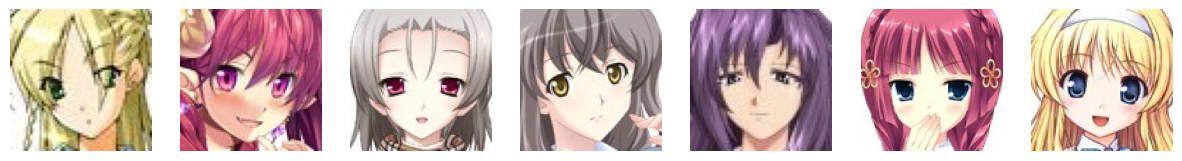

In [4]:
num_images = 7
fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

for i in range(num_images):
    axes[i].imshow(images_train[i])
    axes[i].axis('off')

plt.show()

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [47]:
DIR = '/kaggle/input/animefacedataset'
IMAGE_SIZE = 64
LATENT_SIZE = 128
BATCH_SIZE = 128

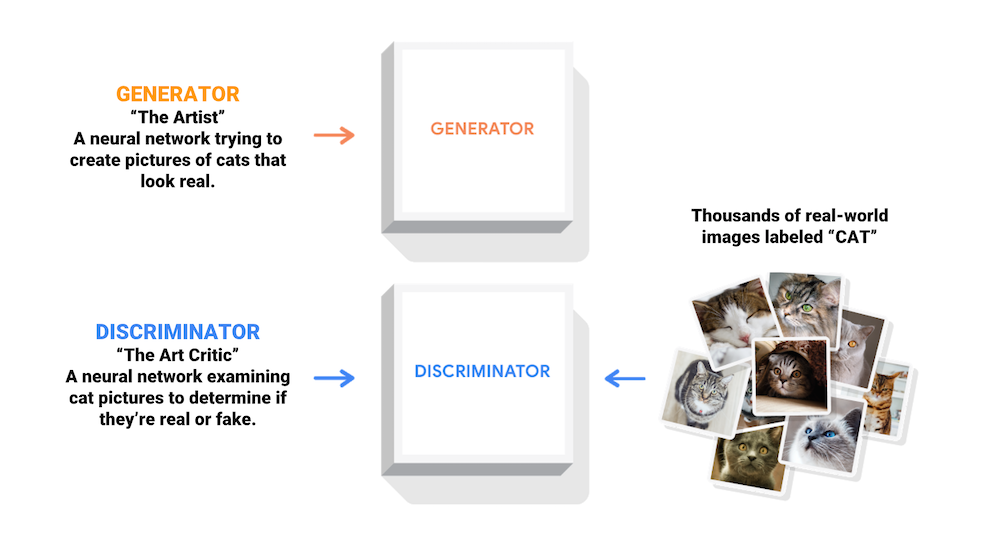!

In [48]:
def create_discriminator_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(1, (4, 4), padding='valid', use_bias=False),
        layers.Flatten(),
        layers.Activation('sigmoid')
    ])
    return model

In [49]:
def create_generator_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(LATENT_SIZE,)),
        layers.Reshape((1, 1, LATENT_SIZE)),
        
        layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh')
    ])
    return model

In [50]:
discriminator = create_discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        3072      
                                                                 
 batch_normalization_16 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_17 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)      

In [51]:
generator = create_generator_model()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 4, 4, 512)         1048576   
 DTranspose)                                                     
                                                                 
 batch_normalization_20 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
                                                                 
 re_lu_8 (ReLU)              (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_11 (Conv2  (None, 8, 8, 256)         2097152   
 DTranspose)                                                     
                                                      

In [52]:
# Функції похибки

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

lr_gen = 0.0002
lr_discr = 0.0002
cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(lr_gen, beta_1=0.8)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_discr, beta_1=0.8)

In [53]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_SIZE])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [54]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DIR, 
    image_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=BATCH_SIZE, 
    label_mode=None
)
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)  # масштабування: [-1, 1]

Found 63565 files belonging to 1 classes.


In [55]:
len(train_dataset)

497

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Progbar

epochs = 25
for epoch in range(epochs):
    print(f'\n== Epoch #{epoch + 1} {20 * "="}')
    # Create a tqdm progress bar for the batches
    progress_bar = Progbar(len(train_dataset))
    
    for i, image_batch in enumerate(train_dataset):
#         print(f'==== Batch # {i + 1}')
        train_step(image_batch)
        progress_bar.update(i) 


== Epoch #1 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #2 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #3 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #4 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #5 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #6 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #7 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #8 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #9 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #10 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #11 ====================
496/497 [============================>.] - ETA: 0s
== Epoch #12 ====================
496/497 [============================>.

In [62]:
num_samples = 9
sample_noise = tf.random.normal([num_samples, LATENT_SIZE])
sample_images = generator(sample_noise)
sample_images = 0.5 * sample_images + 0.5
# sample_images = np.clip(sample_images, 0, 1)

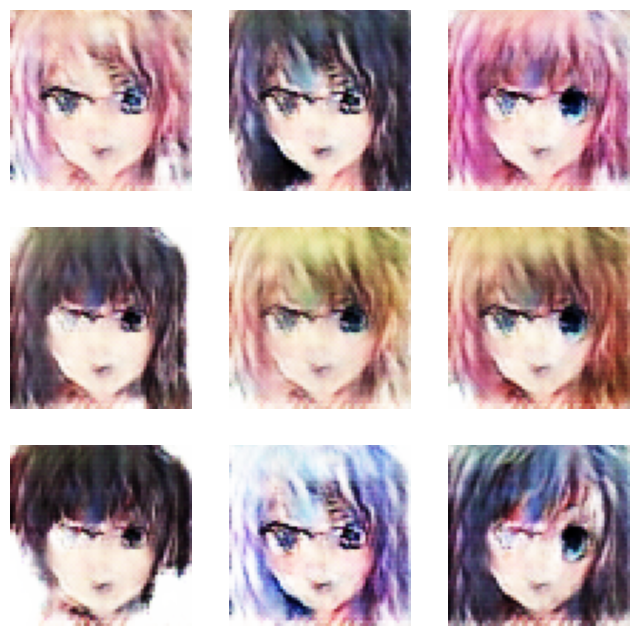

In [63]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(num_samples):
    axs[i // 3, i % 3].imshow(sample_images[i])
    axs[i // 3, i % 3].axis('off')
plt.show()